# Infrapy Quick Start

A series of scripts illustrating how to use infrapy subroutines as stand-alone modules are found in the /examples folder. The Quick Start section of the Infrapy documentation will walk you through running these scripts, or you can run them interactively below.

## Beamforming:

Run Bartlett, Capon or Generalized Least Squares beamforming processes on an hour-long dataset from the BRP array in Utah

In [1]:
import numpy as np
from multiprocess import Pool
import matplotlib.pyplot as plt
import matplotlib.cm as cm
palette = cm.jet
import matplotlib.ticker as mtick
from obspy.core import read
from scipy import signal
from infrapy.detection import beamforming_new

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook

In [2]:
# ######################### #
#     Define Parameters     #
# ######################### #
sac_glob = "../examples/data/*BRP*.SAC" ## load in SAC files for processing

freq_min, freq_max = 0.5, 2.5 ## define frequency band of interest
window_length, window_step = 10.0, 2.5 ## define window length and window step for beamforming

ns_start, ns_end = 100.0, 400.0 ## define noise window (in sec); only needed for GLS processing
sig_start, sig_end = 600, 800 ## define signal window [time window in sec used for analysis]

back_az_vals = np.arange(-180.0, 180.0, 1.5)
trc_vel_vals = np.arange(300.0, 600.0, 2.5)

method="bartlett" ## beamforming method; options are bartlett, capon, GLS

p = Pool(4) ## define number of CPUs used for processing

In [3]:
# ######################### #
#  Read, Shift Start Time,  #
#      and Filter Data      #
# ######################### #
x, t, t0, geom = beamforming_new.stream_to_array_data(read(sac_glob))
M, N = x.shape

<IPython.core.display.Javascript object>


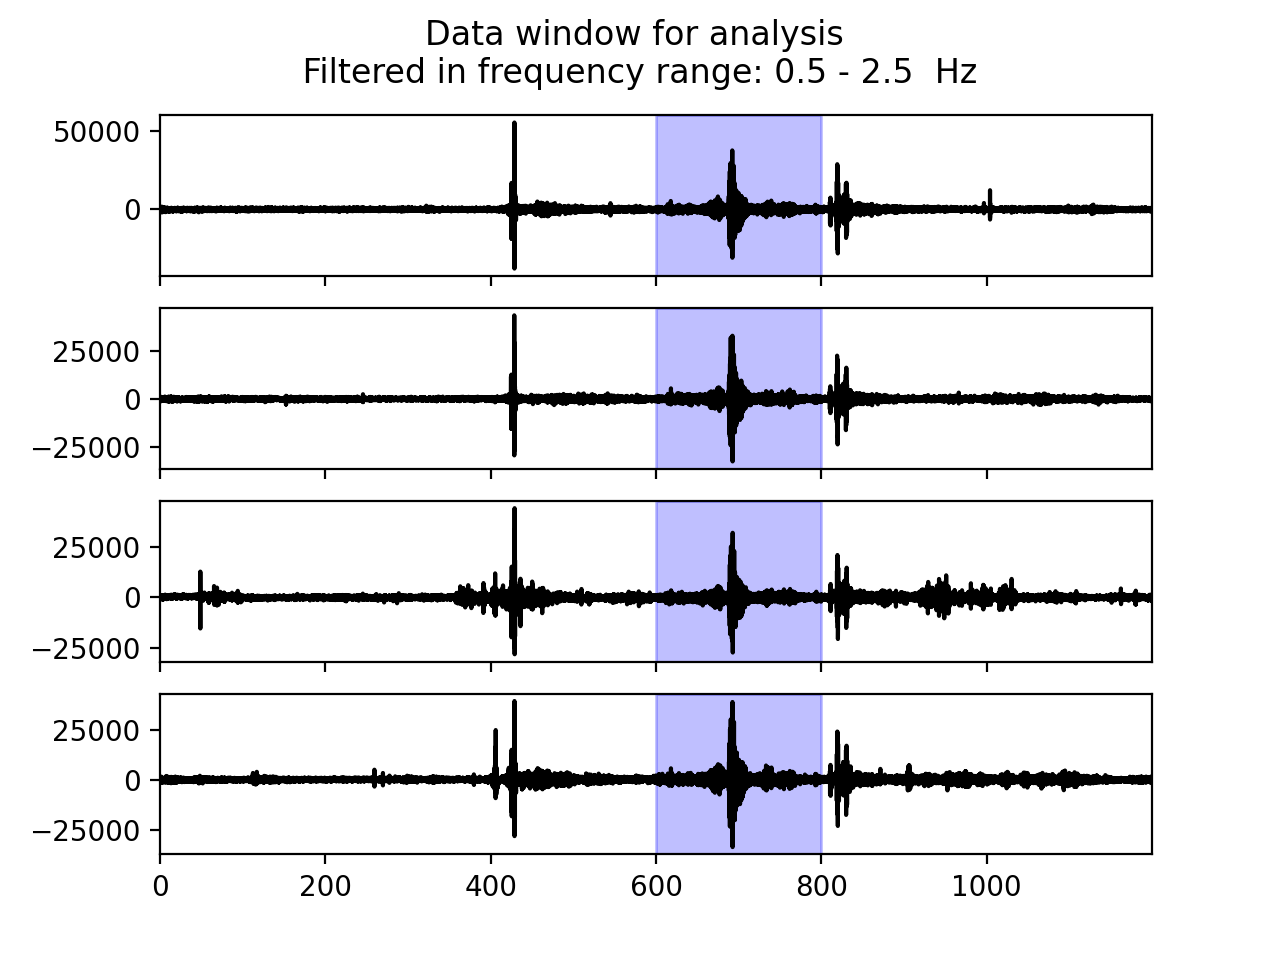

In [4]:
# ######################### #
#         View Data         #
# ######################### #
plt.figure()
for m in range(M):
    plt.subplot(M, 1, m + 1)
    plt.xlim([0, t[-1]])
    plt.plot(t, x[m], 'k-')
    plt.axvspan(xmin = sig_start , xmax = sig_end, alpha = 0.25, color = 'blue')
    if method == "gls":
        plt.axvspan(xmin = ns_start , xmax = ns_end, alpha = 0.25, color = 'red')
    if m < (M - 1) : plt.setp(plt.subplot(M, 1, m + 1).get_xticklabels(), visible=False)

if method == "gls":
    plt.suptitle("Data windows for signal (blue) and noise (red) \n Filtered in frequency range: " + str(freq_min) + " - " + str(freq_max) + "  Hz \n ")
else:
    plt.suptitle("Data window for analysis \n Filtered in frequency range: " + str(freq_min) + " - " + str(freq_max) + "  Hz \n ")

plt.show(block=False)
plt.pause(0.1)

In [5]:
# ######################### #
#        Run Methods        #
# ######################### #

# define slowness and delays
slowness = beamforming_new.build_slowness(back_az_vals, trc_vel_vals)
delays = beamforming_new.compute_delays(geom, slowness)

# define the noise covariance if using generalized least squares method
if method == "gls":
    _, S, _ = beamforming_new.fft_array_data(x, t, window=[ns_start, ns_end], sub_window_len=window_length)

    ns_covar_inv = np.empty_like(S)
    for n in range(S.shape[2]):
        S[:, :, n] += 1.0e-3 * np.mean(np.diag(S[:, :, n])) * np.eye(S.shape[0])
        ns_covar_inv[:, :, n] = np.linalg.inv(S[:, :, n])
else:
    ns_covar_inv = None



# Run beamforming in windowed data and write to file
times, beam_results = [],[]
for window_start in np.arange(sig_start, sig_end, window_step):
    if window_start + window_length > sig_end:
        break

    times = times + [[t0 + np.timedelta64(int(window_start), 's')]]
    X, S, f = beamforming_new.fft_array_data(x, t, window=[window_start, window_start + window_length])
    beam_power = beamforming_new.run(X, S, f, geom, delays, [freq_min, freq_max], method="bartlett", pool=p, normalize_beam=True, ns_covar_inv=ns_covar_inv)
    peaks = beamforming_new.find_peaks(beam_power, back_az_vals, trc_vel_vals, signal_cnt=1)
    beam_results = beam_results + [[peaks[0][0], peaks[0][1], peaks[0][2] / (1.0 - peaks[0][2]) * (x.shape[0] - 1)]]

times = np.array(times)[:, 0]
beam_results = np.array(beam_results)


<IPython.core.display.Javascript object>


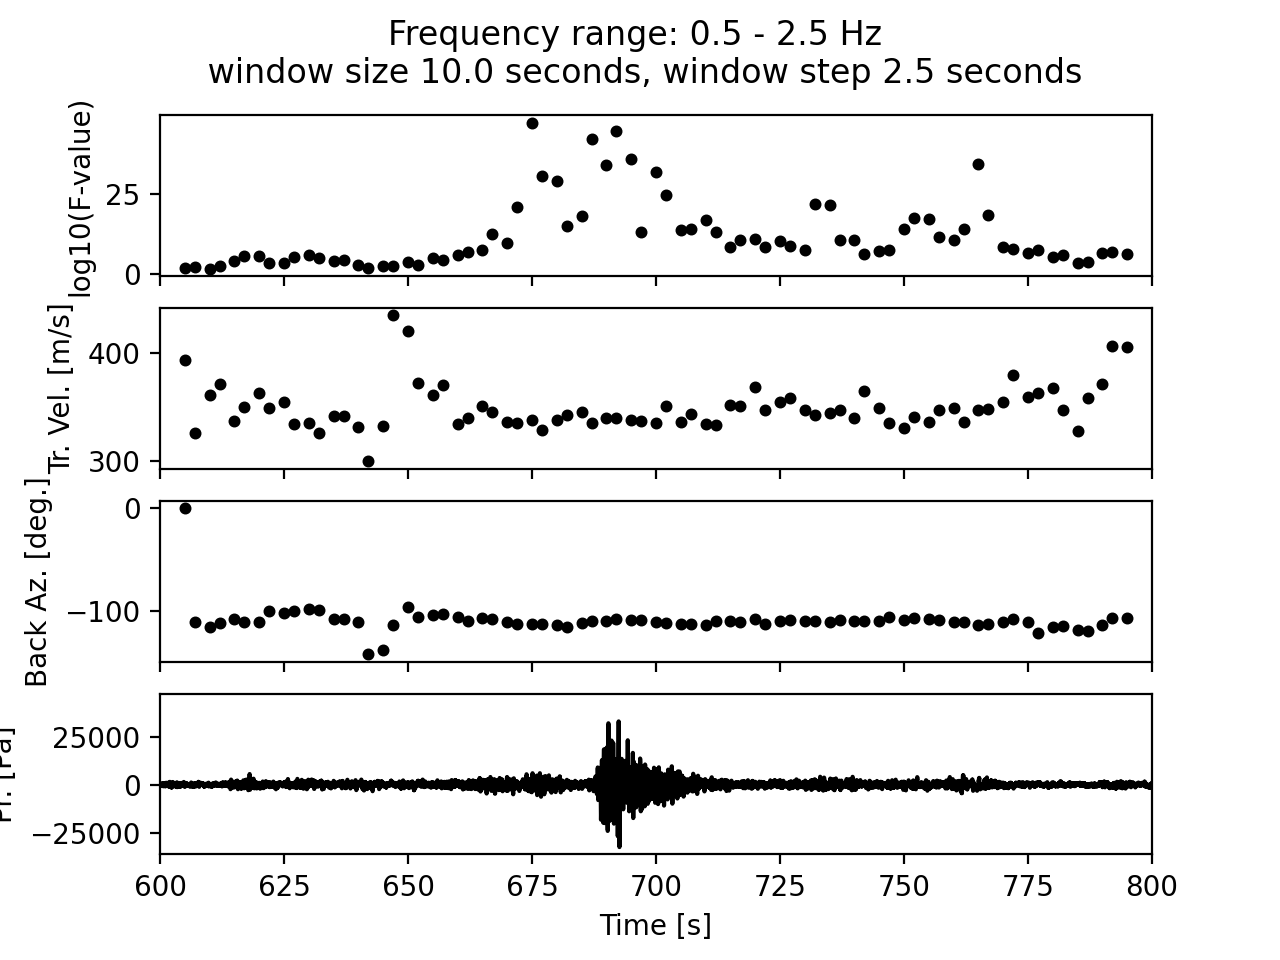

In [6]:
# Prep figure
f, a = plt.subplots(4, sharex=True)
plt.xlim([sig_start, sig_end])
a[3].set_xlabel("Time [s]")
a[3].set_ylabel("Pr. [Pa]")
a[2].set_ylabel("Back Az. [deg.]")
a[1].set_ylabel("Tr. Vel. [m/s]")
if method == "music":
    a[0].set_ylabel("Beam Power")
else:
    a[0].set_ylabel("log10(F-value)")

a[3].plot(t, x[1,:], '-k')
plt.suptitle("Frequency range: " + str(freq_min) + " - " + str(freq_max) + " Hz \n window size " + str(window_length) + " seconds, window step " + str(window_step) +  " seconds")

for aa in range(len(times)):
    dt = times[aa]-times[0]
    start = dt.item().total_seconds() 
    start = start + sig_start
    if method == "music":
        a[2].plot([start + 1.0 / 2.0 * window_length], [beam_results[aa][0]], 'ok', markersize=3.3)
        a[1].plot([start + 1.0 / 2.0 * window_length], [beam_results[aa][1]], 'ok', markersize=3.3)
        a[0].plot([start + 1.0 / 2.0 * window_length], [beam_results[aa][2]], 'ok', markersize=3.3)
        plt.pause(0.1)
    else:
        a[2].plot([start + 1.0 / 2.0 * window_length], [beam_results[aa][0]], 'ok', markersize=3.3)
        a[1].plot([start + 1.0 / 2.0 * window_length], [beam_results[aa][1]], 'ok', markersize=3.3)
        a[0].plot([start + 1.0 / 2.0 * window_length], [beam_results[aa][2]], 'ok', markersize=3.3)
plt.show(block=False)

In [7]:
# ########################## #
#        Save Results        #
# ########################## #

np.save("times", times)
np.save("beam_results", beam_results)

<IPython.core.display.Javascript object>


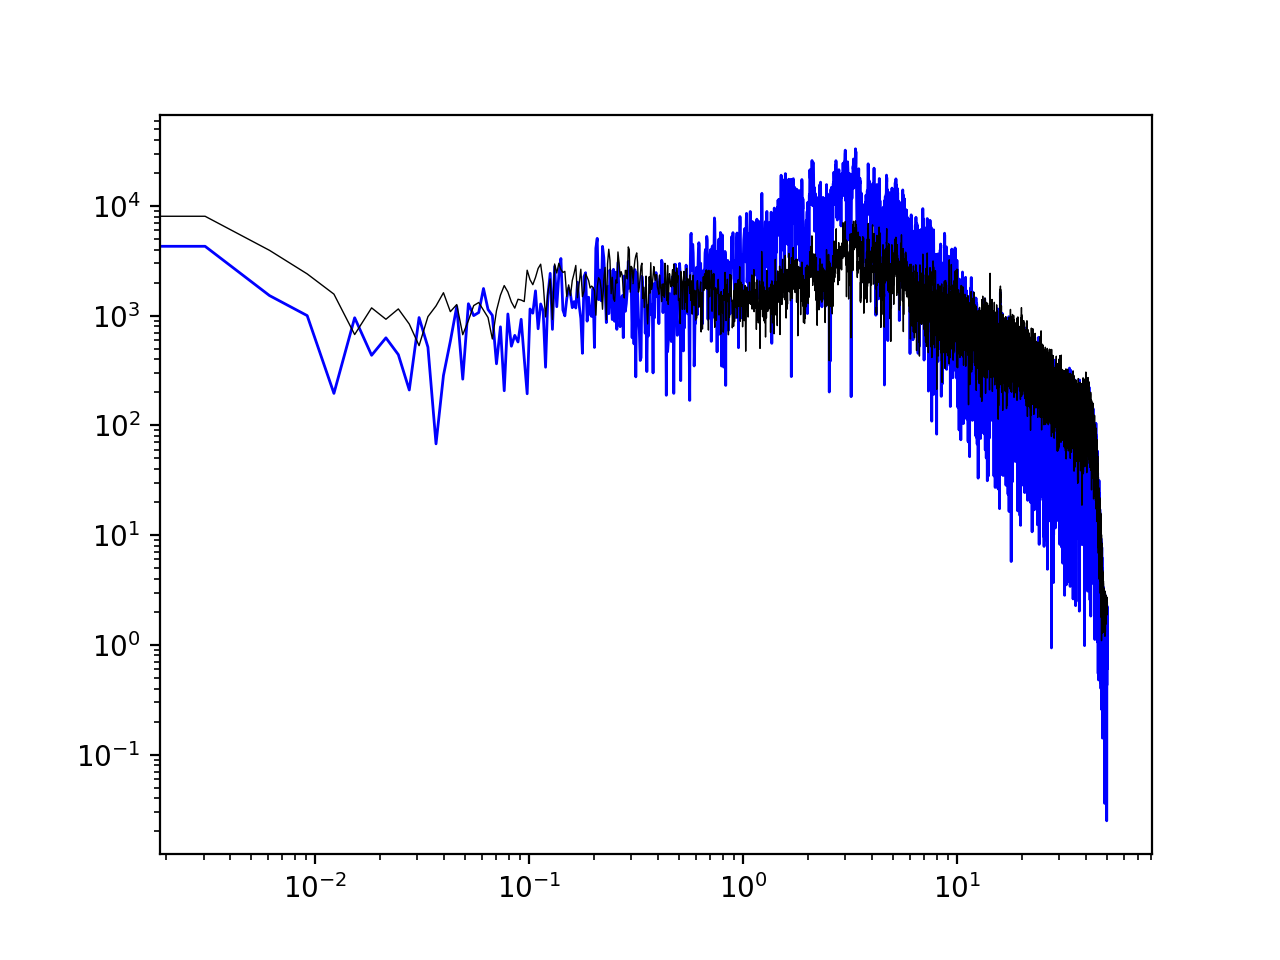

<IPython.core.display.Javascript object>


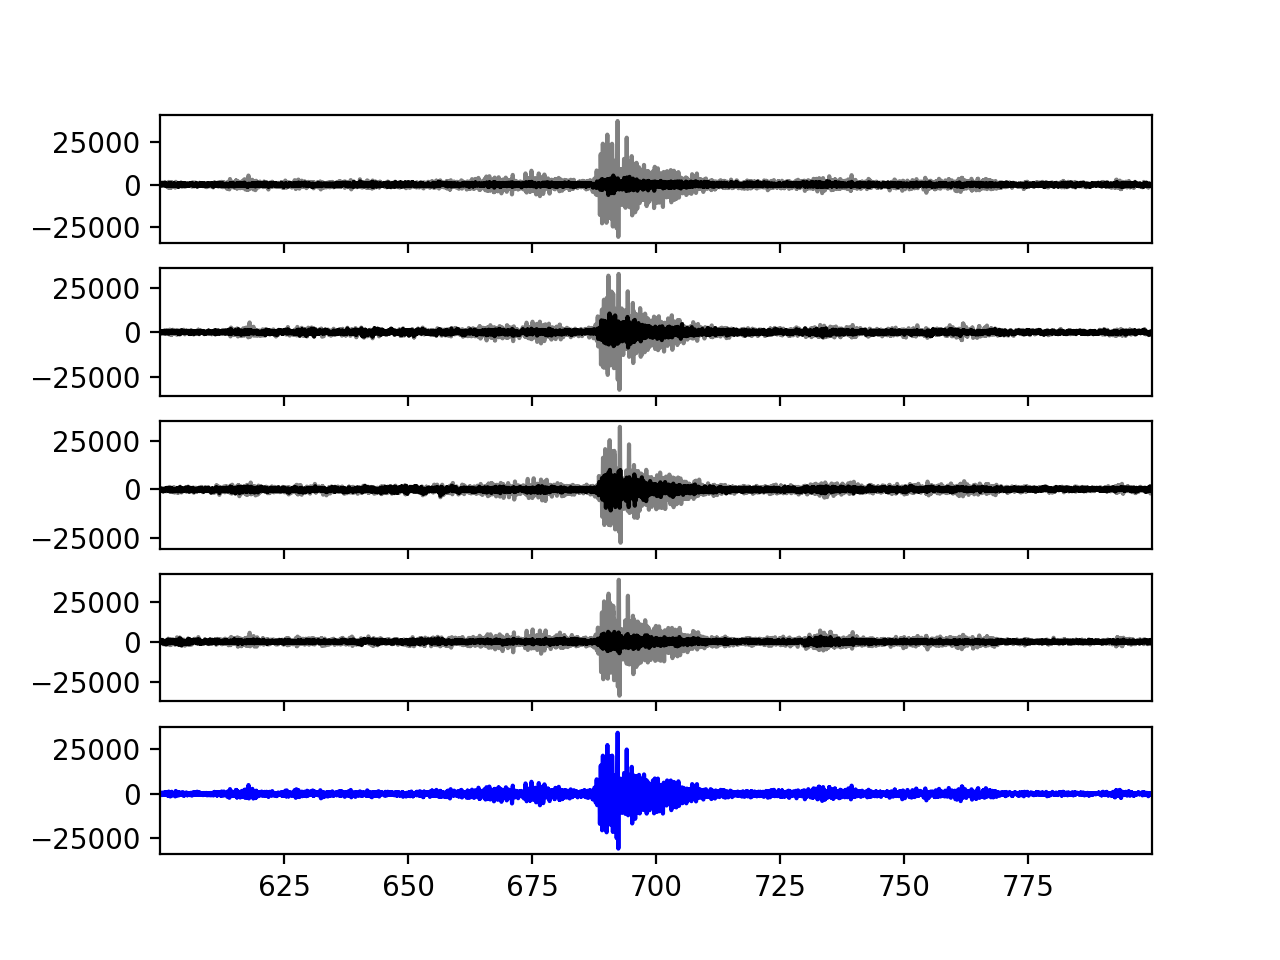

In [8]:
# ####################################### #
#        Define Beam and Residuals        #
# ####################################### #
back_az = beam_results[np.argmax(beam_results[:, 2]), 0]
tr_vel = beam_results[np.argmax(beam_results[:, 2]), 1]

X, S, f = beamforming_new.fft_array_data(x, t, window=[sig_start, sig_end], fft_window="boxcar")
sig_est, residual = beamforming_new.extract_signal(X, f, np.array([back_az, tr_vel]), geom)

plt.figure()
plt.loglog(f, abs(sig_est), '-b', linewidth=1.0)
plt.loglog(f, np.mean(abs(residual), axis=0), '-k', linewidth=0.5)

signal_wvfrm = np.fft.irfft(sig_est) / (t[1] - t[0])
resid_wvfrms = np.fft.irfft(residual, axis=1) / (t[1] - t[0])
t_mask = np.logical_and(sig_start < t, t < sig_end)

plt.figure()
for m in range(M):
    plt.subplot(M + 1, 1, m + 1)
    plt.xlim([t[t_mask][0], t[t_mask][-1]])
    plt.plot(t[t_mask], x[m, t_mask], '0.5')
    plt.plot(t[t_mask], resid_wvfrms[m, :len(t[t_mask])], 'k-')
    plt.setp(plt.subplot(M + 1, 1, m + 1).get_xticklabels(), visible=False)
plt.subplot(M + 1, 1, M + 1)
plt.xlim([t[t_mask][0], t[t_mask][-1]])
plt.plot(t[t_mask], signal_wvfrm[:len(t[t_mask])], 'b-')

## Detection

Run detection on the series of beamforming results produced in the above step 

In [9]:

# ######################### #
#     Define Parameters     #
# ######################### #

# Detection params
# times_file, beam_results_file = None, None
times_file, beam_results_file = "times.npy", "beam_results.npy"

det_win_len = 60 * 5
det_thresh = 0.99
min_seq = 5
det_method = "fstat"
TB_prod = 40 * 10
back_az_lim = 10
M=4

In [10]:
# ################################## #
#   Load data and prepare analysis   #
# ################################## #

if times_file and beam_results_file:
    times = np.load(times_file)
    beam_results = np.load(beam_results_file)
else:
    print('No beamforming input provided')


In [11]:
# ################################## #
#       Run detection analysis       #
# ################################## #
dets = beamforming_new.detect_signals(times, beam_results, det_win_len, det_thresh=det_thresh, min_seq=min_seq, back_az_lim=back_az_lim, method=det_method, TB_prod=TB_prod,channel_cnt=M, use_det_mask=False)


Running detection analysis...
2012-04-09T18:11:10.008300
2012-04-09T18:12:40.008300


In [12]:
# ################################## #
#       Print Detection Summary      #
# ################################## #
print('\n' + "Detection Summary:")
for det in dets:
    print("Detection time:", det[0], '\t', "Rel. detection onset:", det[1], '\t',"Rel. detection end:", det[2], '\t',end=' ')
    print("Back azimuth:", det[3], '\t', "Trace velocity:", det[4], '\t', "F-stat:", det[5], '\t', "Array dim:", M)


Detection Summary:
Detection time: 2012-04-09T18:11:10.008300 	 Rel. detection onset: -8.0 	 Rel. detection end: 57.0 	 Back azimuth: -112.38694574858556 	 Trace velocity: 337.3871140712959 	 F-stat: 47.33049790918546 	 Array dim: 4
Detection time: 2012-04-09T18:12:40.008300 	 Rel. detection onset: -15.0 	 Rel. detection end: 10.0 	 Back azimuth: -113.49115628984059 	 Trace velocity: 346.5323834605423 	 F-stat: 34.3755343870141 	 Array dim: 4


In [13]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx]

<IPython.core.display.Javascript object>


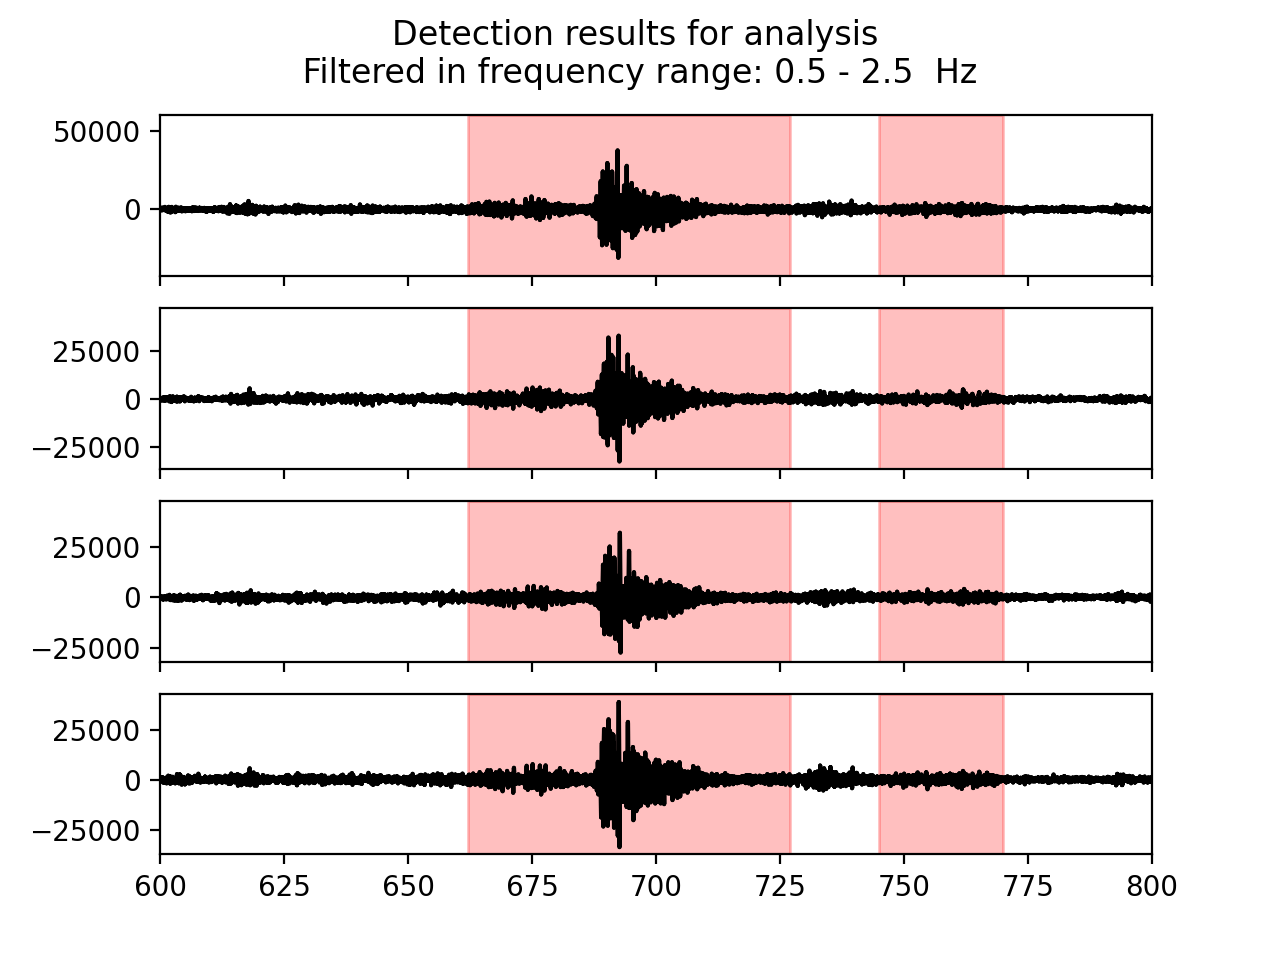

<IPython.core.display.Javascript object>


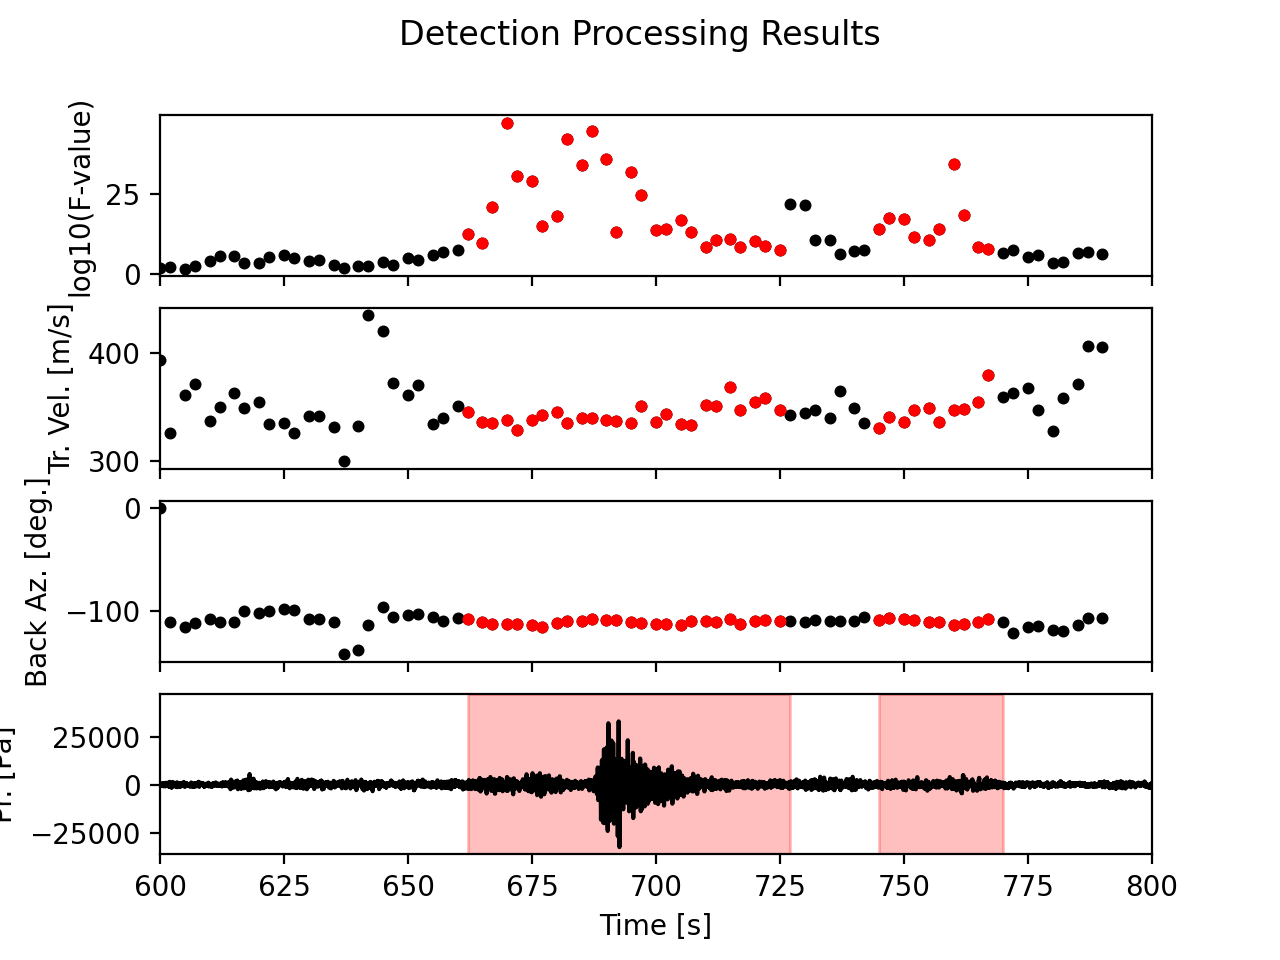

In [14]:
# ################################## #
#       Plot Detection Results       #
# ################################## #

plt.figure()
plt.suptitle("Detection results for analysis \n Filtered in frequency range: " + str(freq_min) + " - " + str(freq_max) + "  Hz \n ")

for det in range(len(dets)):
    dt = dets[det][0]-times[0] 
    start = dt.item().total_seconds() 
    ts = sig_start + start + dets[det][1]
    te = sig_start + start + dets[det][2]
    for m in range(M):
        plt.subplot(M, 1, m + 1)
        plt.xlim([sig_start, sig_end])
        plt.plot(t, x[m], 'k-')
        plt.axvspan(xmin = ts , xmax = te, alpha = 0.25, color = 'red')
        if m < (M - 1) : plt.setp(plt.subplot(M, 1, m + 1).get_xticklabels(), visible=False)
    

f, a = plt.subplots(4, sharex=True)
plt.xlim([sig_start, sig_end])
a[3].set_xlabel("Time [s]")
a[3].set_ylabel("Pr. [Pa]")
a[2].set_ylabel("Back Az. [deg.]")
a[1].set_ylabel("Tr. Vel. [m/s]")
if method == "music":
    a[0].set_ylabel("Beam Power")
else:
    a[0].set_ylabel("log10(F-value)")

a[3].plot(t, x[1,:], '-k')
plt.suptitle("Detection Processing Results")

position = []     
for det in range(len(dets)):
    dt = dets[det][0]-times[0] 
    start = dt.item().total_seconds() 
    ts = sig_start + start + dets[det][1]
    te = sig_start + start + dets[det][2]
    a[3].axvspan(xmin = ts , xmax = te, alpha = 0.25, color = 'red')

    duration = te-ts
    duration = duration/window_step

    for bb in range(0,int(duration),1):
        temp = dets[det][0]+np.timedelta64(int(dets[det][1]),'s')+np.timedelta64(int(window_step*bb),'s')
        det_time=find_nearest(times, temp)
        det_times = np.where(times==det_time)
        pos = det_times[0][0]
        position.append(pos)
for aa in range(len(times)):
    dt = times[aa]-times[0]
    start = dt.item().total_seconds() 
    start = start + sig_start
    a[2].plot([start], [beam_results[aa][0]], 'ok', markersize=3.3)
    a[1].plot([start], [beam_results[aa][1]], 'ok', markersize=3.3)
    a[0].plot([start], [beam_results[aa][2]], 'ok', markersize=3.3)
for aa in position:
    dt = times[aa]-times[0]
    start = dt.item().total_seconds() 
    start = start + sig_start
    a[2].plot([start], [beam_results[aa][0]], 'or', markersize=3.3)
    a[1].plot([start], [beam_results[aa][1]], 'or', markersize=3.3)
    a[0].plot([start], [beam_results[aa][2]], 'or', markersize=3.3)

plt.show(block=False)

Detection #1


<IPython.core.display.Javascript object>


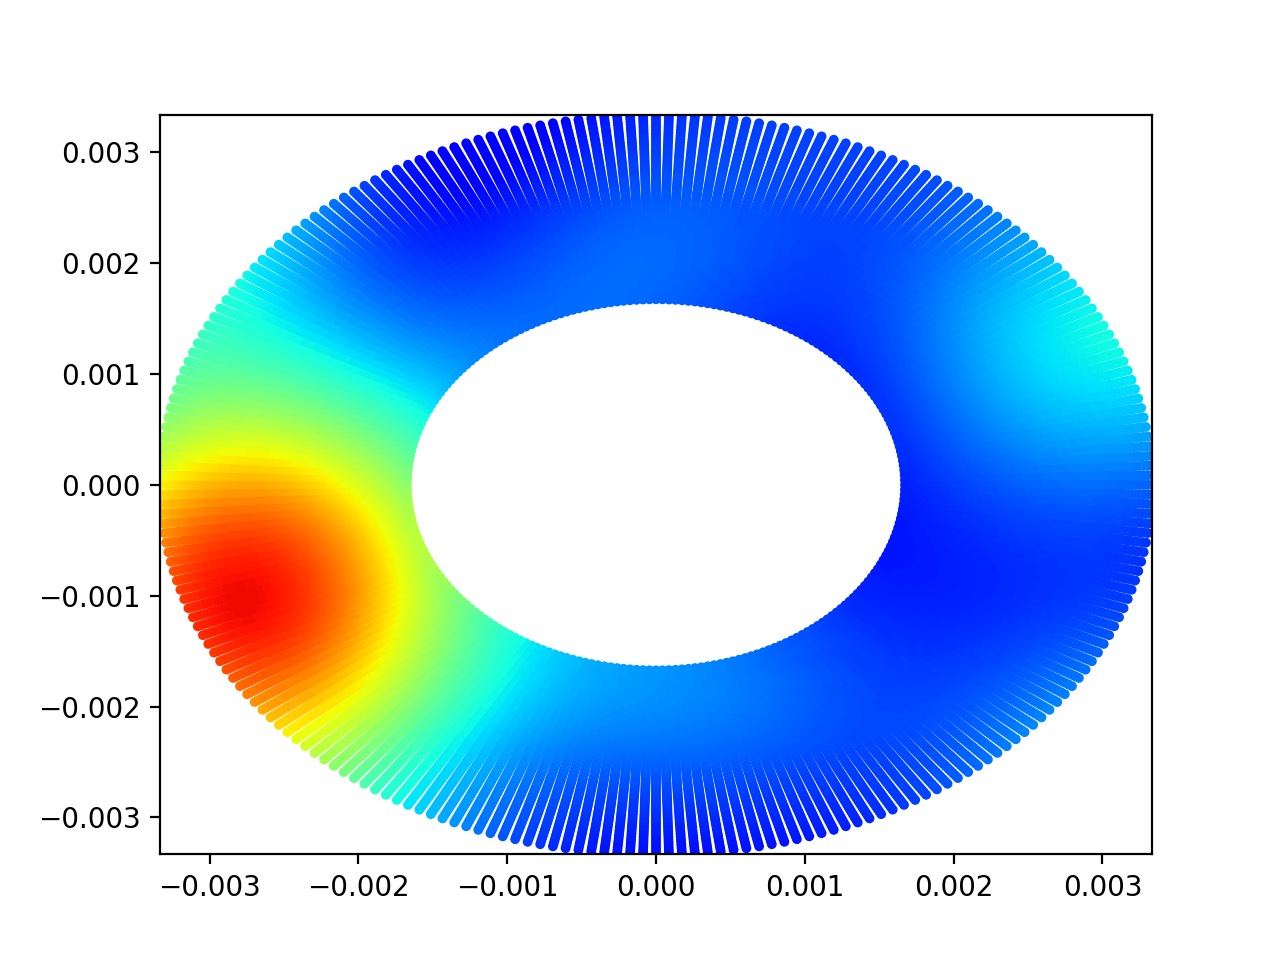

<IPython.core.display.Javascript object>


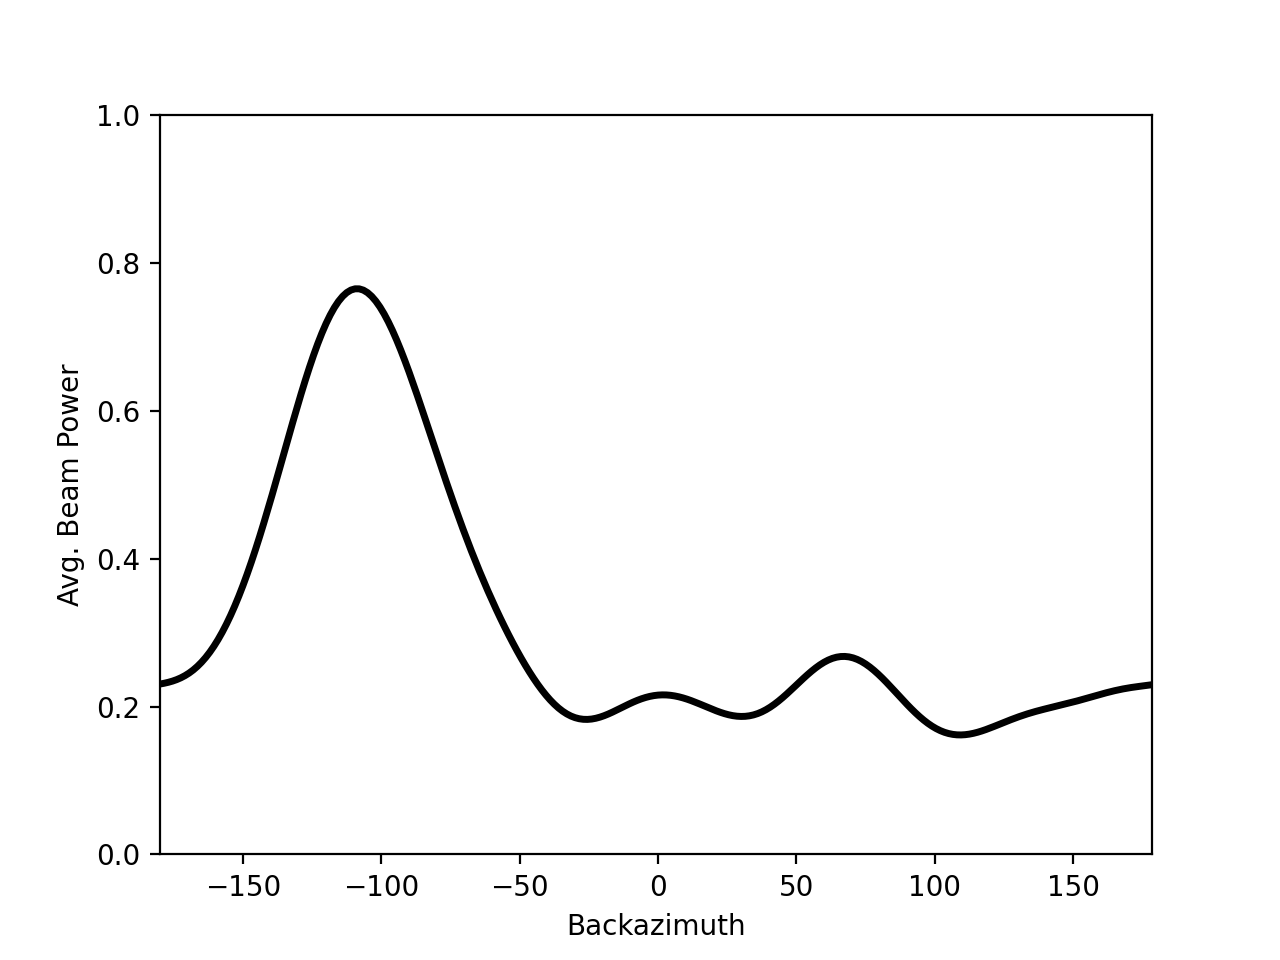

Detection #2


<IPython.core.display.Javascript object>


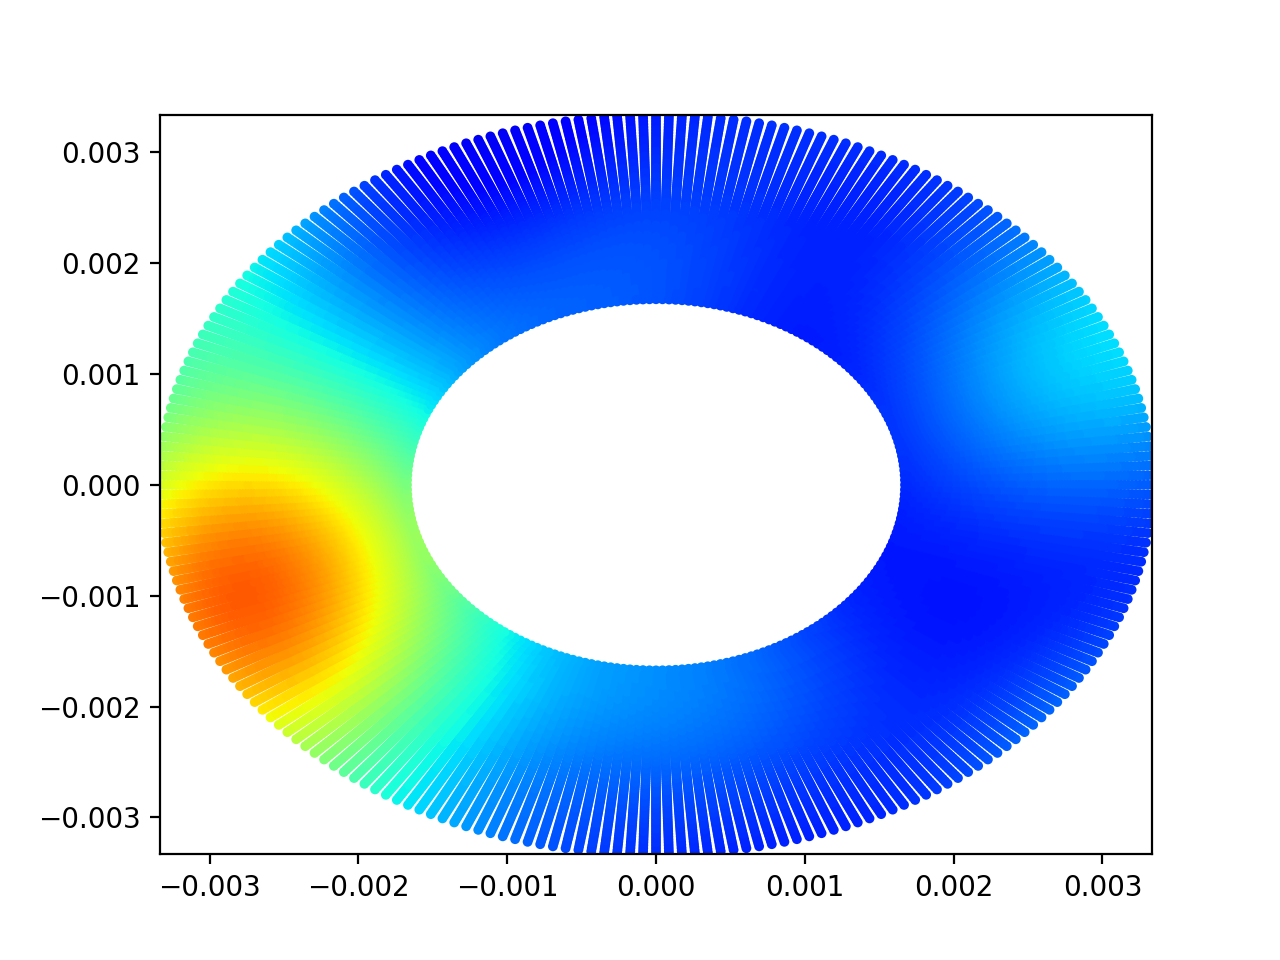

<IPython.core.display.Javascript object>


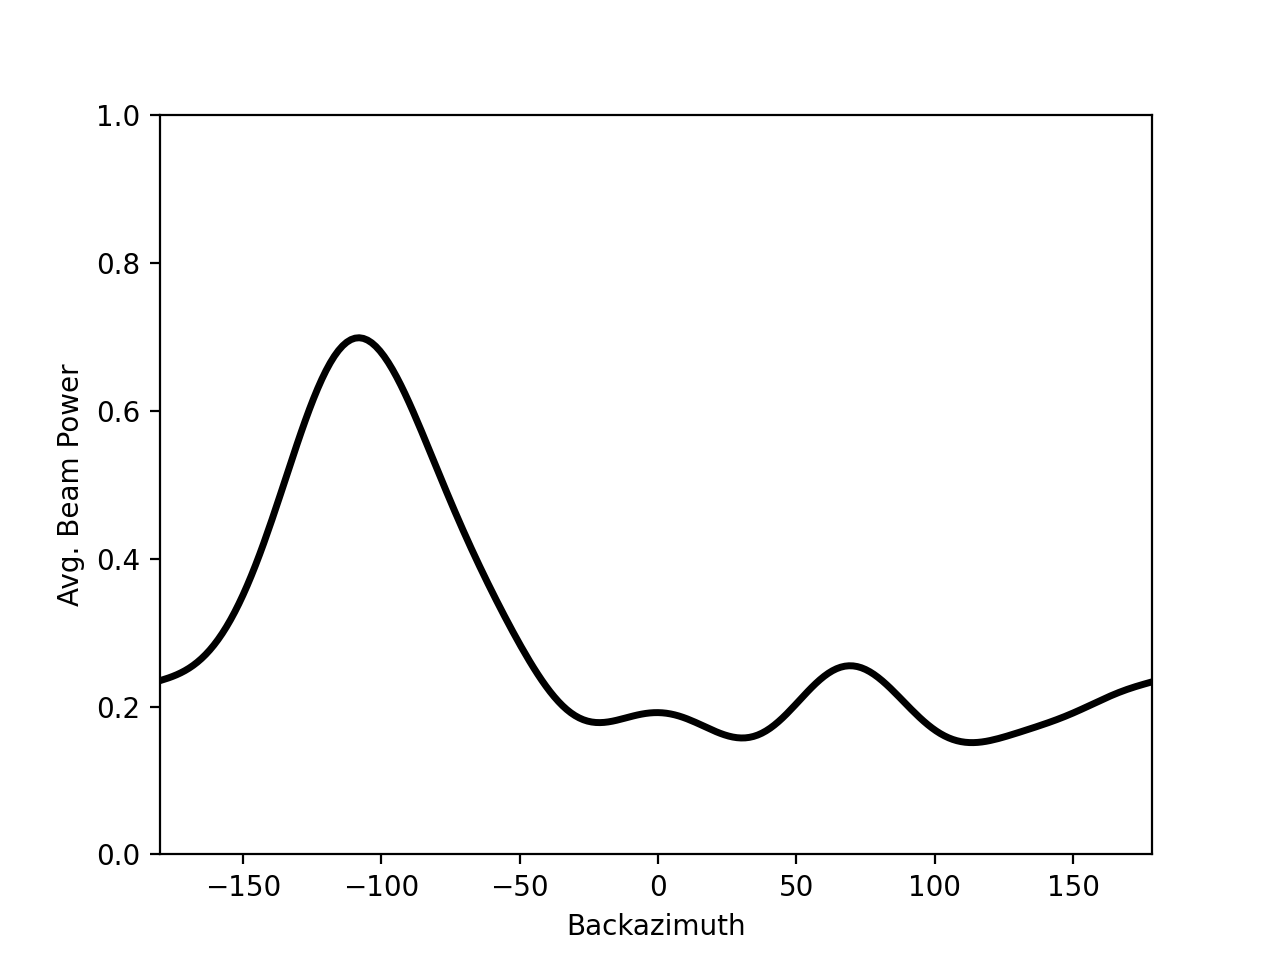

In [15]:
########################################################
##      Plot Detection Results in Slowness Space      ##
########################################################

for det in range(len(dets)):
    dt = dets[det][0]-times[0] 
    start = dt.item().total_seconds() 
    ts = sig_start + start + dets[det][1]
    te = sig_start + start + dets[det][2]
    X, S, f = beamforming_new.fft_array_data(x, t, window=[ts, te])
    beam_power = beamforming_new.run(X, S, f, geom, delays, [freq_min, freq_max], method=method, signal_cnt=1, pool=p, ns_covar_inv=ns_covar_inv, normalize_beam=True)

    avg_beam_power = np.average(beam_power, axis=0)
        #avg_beam_power = beamforming_new.multi_freq_beam(beam_power)
    print('Detection #' + str(det+1))
    plt.figure()
    plt.clf()
    plt.xlim([min(slowness[:, 0]), max(slowness[:, 0])])
    plt.ylim([min(slowness[:, 1]), max(slowness[:, 1])])
    if method == "bartlett_covar" or method == "bartlett" or method == "gls":
        plt.scatter(slowness[:, 0], slowness[:, 1], c=avg_beam_power, cmap=palette, marker="o", s=[12.5] * len(slowness), edgecolor='none', vmin=0.0, vmax=1.0)
    else:
        plt.scatter(slowness[:, 0], slowness[:, 1], c=avg_beam_power, cmap=palette, marker="o", s=[12.5] * len(slowness), edgecolor='none', vmin=0.0, vmax=np.max(avg_beam_power))
    plt.pause(1.0)

    # Compute back azimuth projection of distribution
    az_proj, tv_proj = beamforming_new.project_beam(beam_power, back_az_vals, trc_vel_vals, method="mean")

    plt.figure()
    plt.suptitle("Average Beam Power")

    plt.clf()
    plt.xlim([min(back_az_vals), max(back_az_vals)])
    plt.xlabel('Backazimuth')
    plt.ylabel('Avg. Beam Power')
    if method == "bartlett_covar" or method == "bartlett" or method == "gls":
        plt.ylim([0.0, 1.0])
    else:
        plt.ylim([0.0, np.max(avg_beam_power)])
    plt.plot(back_az_vals, az_proj, '-k', linewidth=2.5)
    plt.pause(0.2)

## Association

Associate a number of detections contained in a .dat file (/data/detection_set1.dat or /data/detection_set2.dat)

In [16]:
import numpy as np
from multiprocess import Pool

from infrapy.association import hjl
from infrapy.propagation import likelihoods as lklhds

In [17]:
#########################
### Define parameters ###
#########################

# Read in detections from file
det_list = lklhds.json_to_detection_list('../examples/data/detection_set1.json')

# define joint-likelihood calculation parameters
width = 10.0
rng_max = 3000.0

# define clustering parameters
dist_max = 10.0
clustering_threshold = 5.0
trimming_thresh = 3.0

pl = Pool(4)

---------------------------------------------------------------------------
Building distance matrix for association analysis...
	Computing joint-likelihoods...	 

<IPython.core.display.Javascript object>


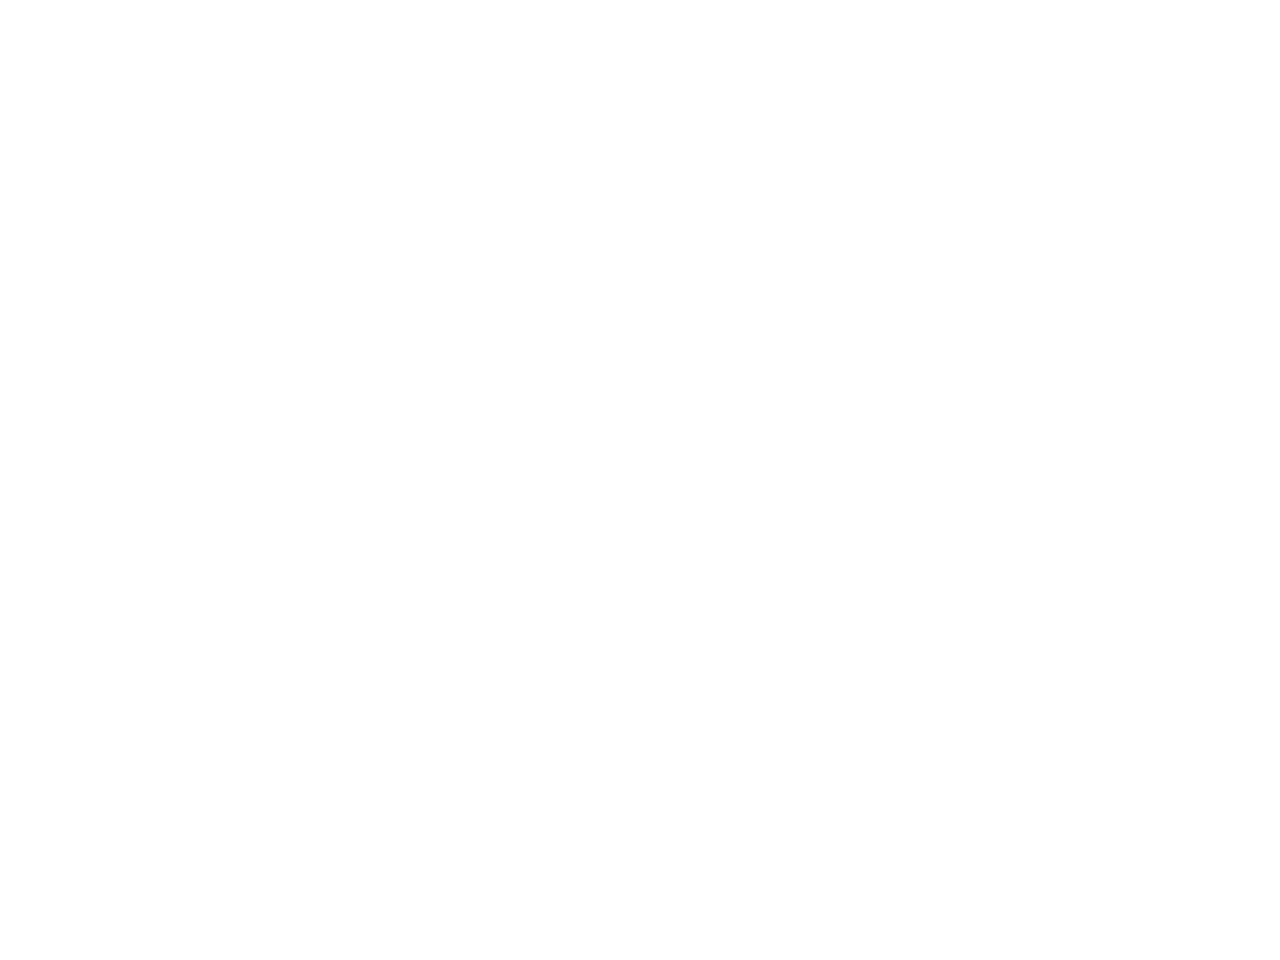

In [18]:

######################
#### Run analysis ####
######################
labels, dists = hjl.run(det_list, clustering_threshold, dist_max=dist_max, bm_width=width, rng_max=rng_max, trimming_thresh=trimming_thresh, pool=pl,show_result=True)


In [19]:
############################
#### Summarize Clusters ####
############################
clusters, qualities = hjl.summarize_clusters(labels, dists)
for n in range(len(clusters)):
    print("Cluster:", clusters[n], '\t', "Cluster Quality:", 10.0**(-qualities[n]))


Cluster: [0, 1, 2, 3] 	 Cluster Quality: 0.02091116792348225
Cluster: [4, 5, 6] 	 Cluster Quality: 0.026282635023863455


## Location

Test the Bayesian Infrasonic Source Localization (BISL) methodology using a set of provided detections (/data/detection_set1.dat or /data/detection_set2.dat).  Location will be run twice, once assuming uniform atmospheric propagation and a second time applying provided atmospheric propagation priors for the Western US (see Blom et al., 2015 for further explanation)

In [20]:
import numpy as np

from infrapy.location import bisl
from infrapy.propagation import likelihoods as lklhds
from infrapy.propagation import infrasound as infsnd

In [21]:
# ######################### #
#       Define Inputs       #
# ######################### #

# Define ground_truth if known (41.131, -112.896 for UTTR; Test includes show in June 2004)
grnd_trth = [41.131, -112.896, np.datetime64('2004-06-02T17:23:04.0')]

# Define localization parameters
bm_width = 12.5
rad_min, rad_max = 50.0, 500.0
rng_max = np.pi / 2.0 * 6370.0
resolution = int(np.sqrt(1e5))

In [22]:
# ################################# #
#       Define Detection List       #
# ################################# #

'''
# Define the list of detections (output from association)
# detection format: (lat, lon, arrival time, back az, F stat, elements)
# arrival time format: datetime.datetime(year, month, day, hour, minute, second)
det1 = lklhds.InfrasoundDetection(42.7668, -109.5939, np.datetime64('2004-06-02T17:42:14.0'), -125.6, 75.0, 4)
det2 = lklhds.InfrasoundDetection(38.4296, -118.3036, np.datetime64('2004-06-02T17:50:38.0'),   56.6, 75.0, 4)
det3 = lklhds.InfrasoundDetection(48.2641, -117.1257, np.datetime64('2004-06-02T18:09:14.0'),  157.5, 75.0, 4)
det_list = [det1, det2, det3]
'''

# Load detection list from flat file
#det_list = lklhds.file2dets("data/detection_set2.dat")

# Load detection list from json file
det_list = lklhds.json_to_detection_list('../examples/data/detection_set2.json')

In [23]:
# ########################## #
#          Run BISL          #
#       in Verbose Mode      #
# ########################## #

# Run analysis without priors
result,pdf = bisl.run(det_list, 
                    bm_width=bm_width,
                    rad_min=rad_min, 
                    rad_max=rad_max, 
                    rng_max=rng_max, 
                    resol=resolution,angle=[-180,180])

summary = bisl.summarize(result)

In [24]:
# ########################## #
#     Display Results       #
# ########################## #

print('-' * 75)
print('BISL Summary\n')
print(summary)
print('\n' + '-'*75 + '\n')

---------------------------------------------------------------------------
BISL Summary

Maximum a posteriori analysis: 
	Source location: 40.852, -113.277 
	Source time: 2004-06-02T17:18:29.990000 
Source location analysis:
	Latitude (mean and variance): 40.852 +/- 33.391 km. 
	Longitude (mean and variance): -113.277 +/- 30.361 km.
	Covariance: -0.136
	Area of 95% confidence ellipse: 19081.988 square kilometers
Source time analysis:
	Mean and variance: 2004-06-02T17:18:46.258000 +/- 108.508 second
	Exact 95% confidence bounds: [2004-06-02T17:15:01.801000, 2004-06-02T17:22:19.758000]


---------------------------------------------------------------------------



In [25]:
# ########################## #
#          Define Priors,    #
#          Load from File    #
#           and Display      #
# ########################## #

model = infsnd.PathGeometryModel()
model.load("../infrapy/propagation/priors/UTTR_models/UTTR_06_1800UTC.pgm")
#model.display()

Loading propagation model parameters from ../infrapy/propagation/priors/UTTR_models/UTTR_06_1800UTC.pgm without smoothing.


In [26]:
# ########################## #
#          Run BISL          #
#       in Verbose Mode      #
# .       With Priors .      #
# ########################## #

result,pdf = bisl.run(det_list, 
                    bm_width=bm_width,
                    rad_min=rad_min, 
                    rad_max=rad_max, 
                    rng_max=rng_max, 
                    resol=resolution,
                    path_geo_model=model,angle=[-180,180])

summary = bisl.summarize(result)

In [27]:
# ########################## #
#     Display Results       #
# ########################## #

print('-' * 75)
print('BISL Summary\n')
print(summary)
print('\n' + '-'*75 + '\n')

---------------------------------------------------------------------------
BISL Summary

Maximum a posteriori analysis: 
	Source location: 40.928, -112.863 
	Source time: 2004-06-02T17:19:22.649000 
Source location analysis:
	Latitude (mean and variance): 40.836 +/- 24.571 km. 
	Longitude (mean and variance): -112.908 +/- 21.936 km.
	Covariance: -0.338
	Area of 95% confidence ellipse: 10145.257 square kilometers
Source time analysis:
	Mean and variance: 2004-06-02T17:18:46.473000 +/- 108.513 second
	Exact 95% confidence bounds: [2004-06-02T17:15:01.540000, 2004-06-02T17:22:20.083000]


---------------------------------------------------------------------------

